In [37]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
def filter_csv_pandas(input_file, instrument_column, target_instrument):
    # Initialize an empty list to store the filtered chunks
    filtered_chunks = []

    # Iterate through the CSV file in chunks
    for chunk in pd.read_csv(input_file, chunksize=10000):
        # Filter rows where the instrument column has the value "A"
        if instrument_column in chunk.columns:
            filtered_chunk = chunk[chunk[instrument_column] == target_instrument]
            
            # If the filtered chunk is not empty, add it to our list
            if not filtered_chunk.empty:
                filtered_chunks.append(filtered_chunk)
    
    # Concatenate all filtered chunks into a single DataFrame
    if filtered_chunks:
        return pd.concat(filtered_chunks, ignore_index=True)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no matching rows found


time = "2024-09-27_03:27" # EUR_USD_M15 - AUD_CAD_M15
time = "2024-09-27_03:35" # EUR_GBP_M15 - EUR_CAD_M15

raw_df = filter_csv_pandas(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv", "instrument", "EUR_CAD_M15")

In [42]:
df = raw_df[(raw_df["test_sharpe_ratio"] >= 0.1) | (raw_df["test_inverse_sharpe_ratio"] >= 0.1)]

df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed,instrument,num_perceptually_important_points
2150,1,0.45,45.0,48,0.12,12.0,12,45.0,3.169539,12.0,-0.228984,0.107757,1,70,gaussian_mixture,5,2,578,EUR_CAD_M15,6
2151,2,0.29,29.0,45,0.18,18.0,18,74.0,3.169539,30.0,-0.228984,0.107757,1,70,gaussian_mixture,5,2,578,EUR_CAD_M15,6
2152,3,0.32,32.0,47,0.10,10.0,10,106.0,3.169539,40.0,-0.228984,0.107757,1,70,gaussian_mixture,5,2,578,EUR_CAD_M15,6
2153,4,0.50,50.0,63,0.01,1.0,1,156.0,3.169539,41.0,-0.228984,0.107757,1,70,gaussian_mixture,5,2,578,EUR_CAD_M15,6
2154,5,0.59,59.0,60,0.00,0.0,12,215.0,3.169539,41.0,-0.228984,0.107757,1,70,gaussian_mixture,5,2,578,EUR_CAD_M15,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876219,162,0.43,43.0,78,0.09,9.0,11,7752.0,3.239132,-422.0,-0.325300,0.154144,1,90,gaussian_mixture,10,2,877,EUR_CAD_M15,5
876220,163,0.45,45.0,77,-0.15,-15.0,15,7797.0,3.239132,-437.0,-0.325300,0.154144,1,90,gaussian_mixture,10,2,877,EUR_CAD_M15,5
876221,164,0.43,43.0,73,-0.08,-8.0,8,7840.0,3.239132,-445.0,-0.325300,0.154144,1,90,gaussian_mixture,10,2,877,EUR_CAD_M15,5
876222,165,0.38,38.0,88,-0.09,-9.0,9,7878.0,3.239132,-454.0,-0.325300,0.154144,1,90,gaussian_mixture,10,2,877,EUR_CAD_M15,5


In [44]:
# Filter the dataframe by some dummy columns
df = df[(df["clustering_algorithm"] == 'kmeans')]
df = df[(df["num_clusters"] == 90)]
df = df[(df["random_seed"] == 578)]
df = df[(df["train_period"] == 10)]
df = df[(df["num_perceptually_important_points"] == 5)]

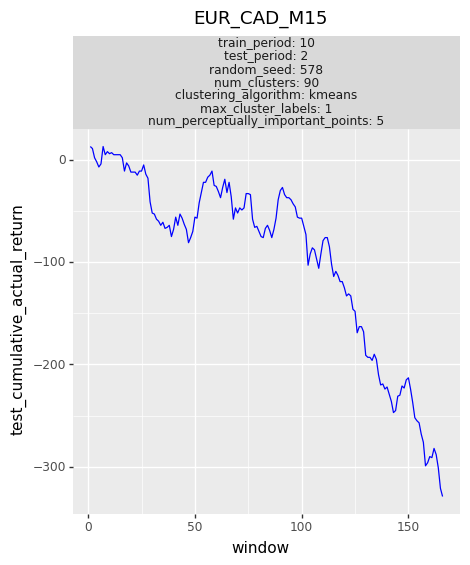

In [45]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels + num_perceptually_important_points", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(5, 5))
# p = p + theme(figure_size=(35, 35))
instrument = df['instrument'].iloc[0]
algo = df['clustering_algorithm'].iloc[0]
p = p + ggtitle(instrument)
print(p)

In [46]:
output_path = f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures/{instrument}_{algo}.png"
# save the df
df.to_csv(output_path.replace(".png", ".csv"), index=False)
p.save(output_path, dpi=300)

/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/strategy_figures/EUR_CAD_M15_kmeans.png
